Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Do not edit or insert code into the test cells as all you insert will be overwritten by the automated testing code.

---

**Question 7**: The code in the cell below has errors. There are errors in style, warnings and convention errors. There are also errors preventing the code to run as intended. 

Your **task** is to find all mistakes, remove them, make the code function properly such that it presents a correct figure at the end and achieves a 10 out of 10 marks from the style checker. 

A brief text at the top of the code in comments explains what the code is meant to be doing. It is strongly recommended to start the exercise by copying the entire code to a separate python file and examine it in Spyder. The code checking should then improve your style mark and potentially give hints on errors which the style checker (and Spyder) can not detect.

**Note A**: Leave the function names unchanged. Some will be assumed in tests. Constant values as given are all correct.

**Note B**: Make sure you use the `pylintrc` file from Moodle. Every integer increase in the style mark (0 to 8, 8 to 9, 9 to 10) gains you one point on the style mark, i.e. up to 3 in total.

**Note C**: This exercise involves random numbers hence every figure will look different. Getting a figure at all is already a success. Marking of figures is manual hence checks will be made to see whether a correct figure emerges even if that means running your code several times due to the built in randomness.

**Note D**: The number of pulses produced follows the Poisson distribution and a single pulse is a valid outcome for the sequence. However, checking that your code works correctly, re-run until you see an example with Npulses>1 fully analysed. Only then can you be certain that all mistakes have been removed.

**Note E**: Copy your final solution back into the cell below so that the tests can run.

n pulses:  4
npe:  1
next onset:  518.7217303383754
npe:  1
in filtered:  [ 51.5 520. ]
[ 4.93506122e+00  5.02798780e+01  3.46319379e-01  1.21545513e+03
 -2.80801819e+00  7.13883623e+02  1.45207176e+02  1.25259107e+03]


/tmp/ipykernel_10400/1713803542.py:34: RuntimeWarning: overflow encountered in exp
  singlepulse = np.exp(-(time - start) / rt) - np.exp(-(time - start) / dt)
/tmp/ipykernel_10400/1713803542.py:37: RuntimeWarning: overflow encountered in multiply
  return -1 * amplitude * singlepulse


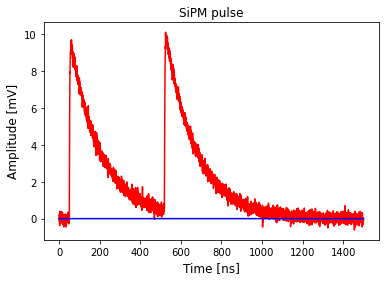

In [8]:
'''
SiPM single event modelling
(a) Make a pulse, always 50 ns after the start of the event.
(b) Randomly decide with the dark count rate how many
    additional pulses should be created.
(c) for more than zero, add additional pulses with random amplitude
    in discrete units of scale and random position in time
    according to exponential distribution and dark count rate.
(d) Analyse event: first filter with matched filter and find peaks.
(e) Use results on peak positions and number to fit all peaks,
    especially if there are more than one.
(f) Draw data and fit.
'''

import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


def matchedFilter(data, template):
    return np.correlate(data, template, mode='full')


def pulseSequence(t, *pos):
    total = np.zeros_like(t)
    for idx in range(0, len(pos) - 3, 4):  # superposition of pulses
        total += pulse(t, pos[idx], pos[idx + 1], pos[idx + 2], pos[idx + 3])
    return total


def pulse(time, amplitude, start, rt, dt):
    singlepulse = np.exp(-(time - start) / rt) - np.exp(-(time - start) / dt)
    singlepulse[np.where(
        time < start)] = 0.0  # not defined before onset time, set 0
    return -1 * amplitude * singlepulse


def makeTemplate(rt, dt):
    timevalues = np.linspace(0, 50, 101)  # 0.05 mus, 0.5 unit step size
    scale = 1.0  # some scale factor giving reasonable values
    onset = 0.0  # pulse start [ns]
    dummy = pulse(timevalues, scale, onset, rt, dt)
    template = dummy / np.trapz(dummy, x=timevalues)  # normalized
    return timevalues, template


def dataProduction(time, cfg):
    amp = cfg[0]  # some scale factor giving reasonable values
    start = cfg[1]  # pulse start [ns]
    rtime = cfg[2]  # realistic rise time
    dtime = cfg[3]  # realistic decay time
    noiselevel = cfg[4]  # noise level scale
    dcr = cfg[5]  # [1/ns] => 2 MHz

    framestop = time[-1]  # final time bin

    Npulses = np.random.poisson(framestop * dcr)
    print('n pulses: ', Npulses)

    pp = pulse(time, amp, start, rtime, dtime)
    noisy = np.random.normal(pp, scale=noiselevel)
    frame = noisy  # first triggered pulse at onset
    for _ in range(Npulses):  # additional pulses
        npe = np.random.poisson(1.0)  # n photo electrons given DCR
        print('npe: ', npe)
        pretrigger = start
        triggertime = random.expovariate(dcr)  # rate parameter
        start = pretrigger + triggertime
        if start > framestop - 300:
            break
        if npe > 0:
            print('next onset: ', start)
            pp = pulse(time, npe * amp, start, rtime, dtime)
            frame += pp
    return frame


def analysis(tvalues, data, cfg):
    scale = cfg[0]  # some scale factor giving reasonable values
    rtime = cfg[2]  # realistic rise time
    dtime = cfg[3]  # realistic decay time

    # prepare the analysis with the matched filter - get a template pulse
    time, tplt = makeTemplate(rtime, dtime)
    time -= time[-1]
    filtered = matchedFilter(result, tplt)  # filter
    responsetime = np.concatenate((time[:-1], tvalues), axis=None)

    # search the filtered result for peaks in response
    peakfilt, _ = find_peaks(filtered, height=6.0, distance=6.0)
    print('in filtered: ', responsetime[peakfilt])

    # fit the pulse, try similar initial values to construction
    # and the identified peak number and positions
    if responsetime[peakfilt].size == 0:
        return None  # failed peak finding
    init = []

    # construct the initial parameter array
    for val in peakfilt:
        init.append([scale, val, rtime, dtime])
    try:
        fitParams, _ = curve_fit(pulseSequence,
                                 tvalues,
                                 result,
                                 p0=np.array(init))
        print(fitParams)
    except (RuntimeError, ValueError):
        fitParams = None  # failed fit

    return fitParams


# Start main script
# make a pulse, consider times in nano seconds [ns]
timevalues = np.linspace(0, 1500, 3001)  # 1.5 mus, 0.5 unit step size
scale = 10.0  # some scale factor giving reasonable values
risetime = 2.0  # realistic rise time
decaytime = 150.0  # realistic decay time
onset = 50.0  # pulse start [ns]
nlevel = 0.2  # noise level scale
darkCountRate = 0.002  # [1/ns] => 2 MHz
config = [scale, onset, risetime, decaytime, nlevel, darkCountRate]

# Data production first
result = dataProduction(timevalues, config)

# then analyse the event
bestfit = analysis(timevalues, result, config)

# finally plotting
plt.plot(timevalues, result, 'r-')
if bestfit is not None:
    plt.plot(timevalues, pulseSequence(timevalues, bestfit), 'b-')
plt.title('SiPM pulse', size=12)
plt.xlabel('Time [ns]', size=12)
plt.ylabel('Amplitude [mV]', size=12)

plt.show()


In [37]:
# Test cell
pp = pulse(timevalues, scale, onset, risetime, decaytime)
mx = np.amax(pp)
mi = np.amin(pp)
assert(abs(mx)>abs(mi)), 'wrong pulse polarity'

In [26]:
# Hidden test cell, tests analysis function

In [ ]:
# Hidden test cell, tests analysis function

### Tests - 3 marks; Style - 3 marks; Plot - 2 marks